In [1]:
import os
os.chdir(r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\timeseires')

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [5]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [7]:
def MLP():
    model = Sequential()
    model.add(Flatten(input_shape=(time_steps , num_features)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    return model

In [9]:
model1 = MLP()
model1.summary()

D:\anconda\envs\MLLab\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 504)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          16,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,193 (63.25 KB)

 Trainable params: 16,193 (63.25 KB)

 Non-trainable params: 0 (0.00 B)

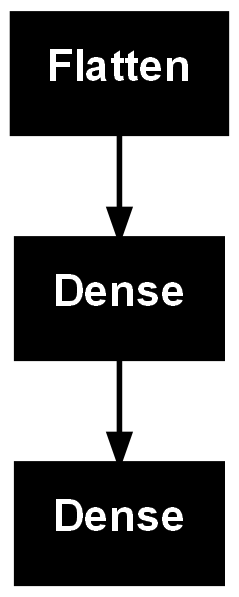

In [11]:
tensorflow.keras.utils.plot_model(model1 )

In [13]:
checkpoints = r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7'
#FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
#JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [15]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
#TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1]

In [17]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =MLP()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [19]:
import os
path_dataset =r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

D:\anconda\envs\MLLab\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((84907, 21), (24259, 21), (12130, 21))

In [21]:
df_te.head(1)

,aep,Is_holiday1,Is_holiday2,Is_Weekend1,Is_Weekend2,sin_month,cos_month,sin_week,cos_week,sin_hour,...,sin_wintert,cos_wintert,sin_springt,cos_springt,sin_summert,cos_summert,sin_fallt,cos_fallt,sin_year_dayt,cos_year_dayt
0,0.518532,1.0,0.0,1.0,0.0,1.0,6.123234e-17,0.866025,-0.5,-0.707107,...,0.0,1.0,1.0,6.123234e-17,0.0,1.0,0.0,1.0,0.956235,0.2926


In [23]:
test_set[0]

array([ 5.18532385e-01,  1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  6.12323400e-17,  8.66025404e-01,
       -5.00000000e-01, -7.07106781e-01, -7.07106781e-01,  0.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  6.12323400e-17,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  1.00000000e+00,  9.56234827e-01,
        2.92600336e-01])

In [25]:
time_steps=2
num_features=21

In [29]:
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=0)

In [31]:
train_X[0]

array([[ 1.69100212e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e-01,
         2.58819045e-01,  9.65925826e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         6.12323400e-17, -9.99768502e-01,  2.15160974e-02],
       [ 1.41395233e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e-01,
         5.00000000e-01,  8.66025404e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         6.12323400e-17, -9.99768502e-01,  2.15160974e-02]])

In [33]:
train_y[0]

array([], dtype=float64)

In [35]:
time_steps =24
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=1,target_len=2)

In [37]:
train_X[0]

array([[ 1.69100212e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e-01,
         2.58819045e-01,  9.65925826e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         6.12323400e-17, -9.99768502e-01,  2.15160974e-02],
       [ 1.41395233e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e-01,
         5.00000000e-01,  8.66025404e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         6.12323400e-17, -9.99768502e-01,  2.15160974e-02],
       [ 1.26232372e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e

In [39]:


train_y[0]

array([1., 1.])

In [41]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.8666398525238037 sec


In [43]:
epochs = 30
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                    verbose = verbose)

Epoch 1/30
2639/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0867 - mae: 0.0867 - mape: 1888.4293
Epoch 1: val_loss improved from inf to 0.03269, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0001-loss0.03.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0865 - mae: 0.0865 - mape: 1887.0187 - val_loss: 0.0327 - val_mae: 0.0327 - val_mape: 13.5882
Epoch 2/30
2636/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0283 - mae: 0.0283 - mape: 1039.8761
Epoch 2: val_loss improved from 0.03269 to 0.02440, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0002-loss0.02.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0283 - mae: 0.0283 - mape: 1035.5439 - val_loss: 0.0244 - val_mae: 0.0244 - val_mape: 10.4266
Epoch 3/30
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239 - mae: 0.0239 - mape: 1421.8859
Epoch 3: val_loss improved from 0.02440 to 0.01905, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0003-loss0.02.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0239 - mae: 0.0239 - mape: 1421.1344 - val_loss: 0.0191 - val_mae: 0.0191 - val_mape: 8.6693
Epoch 4/30
2645/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - mae: 0.0216 - mape: 22.4669
Epoch 4: val_loss did not improve from 0.01905
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0216 - mae: 0.0216 - mape: 22.9354 - val_loss: 0.0205 - val_mae: 0.0205 - val_mape: 9.3313
Epoch 5/30
2638/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198 - mae: 0.0198 - mape: 6.4603
Epoch 5: val_loss did not improve from 0.01905
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0198 - mae: 0.0198 - mape: 6.5620 - val_loss: 0.0205 - val_mae: 0.0205 - val_mape: 8.4452
Epoch 6/30
2637/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - mae: 0.0192 - mape: 92.3184
Epoch 6: val_loss improved from 0.01905 to 0.01852, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0006-loss0.02.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0192 - mae: 0.0192 - mape: 93.1367 - val_loss: 0.0185 - val_mae: 0.0185 - val_mape: 8.7869
Epoch 7/30
2643/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mae: 0.0181 - mape: 162.9848
Epoch 7: val_loss improved from 0.01852 to 0.01807, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0007-loss0.02.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0181 - mae: 0.0181 - mape: 163.1457 - val_loss: 0.0181 - val_mae: 0.0181 - val_mape: 8.3610
Epoch 8/30
2642/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - mae: 0.0176 - mape: 388.9093
Epoch 8: val_loss improved from 0.01807 to 0.01620, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0008-loss0.02.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0176 - mae: 0.0176 - mape: 390.1920 - val_loss: 0.0162 - val_mae: 0.0162 - val_mape: 6.7488
Epoch 9/30
2636/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - mae: 0.0171 - mape: 61.7367
Epoch 9: val_loss improved from 0.01620 to 0.01589, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0009-loss0.02.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0171 - mae: 0.0171 - mape: 66.0966 - val_loss: 0.0159 - val_mae: 0.0159 - val_mape: 6.6553
Epoch 10/30
2645/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - mae: 0.0168 - mape: 654.3130
Epoch 10: val_loss did not improve from 0.01589
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0168 - mae: 0.0168 - mape: 655.2391 - val_loss: 0.0170 - val_mae: 0.0170 - val_mape: 7.9600
Epoch 11/30
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - mae: 0.0162 - mape: 298.7839
Epoch 11: val_loss improved from 0.01589 to 0.01514, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0011-loss0.02.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0162 - mae: 0.0162 - mape: 298.8357 - val_loss: 0.0151 - val_mae: 0.0151 - val_mape: 6.6324
Epoch 12/30
2643/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160 - mae: 0.0160 - mape: 462.1736
Epoch 12: val_loss improved from 0.01514 to 0.01482, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0012-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0160 - mae: 0.0160 - mape: 462.3702 - val_loss: 0.0148 - val_mae: 0.0148 - val_mape: 7.4456
Epoch 13/30
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mae: 0.0158 - mape: 5.8489
Epoch 13: val_loss did not improve from 0.01482
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0158 - mae: 0.0158 - mape: 6.6009 - val_loss: 0.0150 - val_mae: 0.0150 - val_mape: 6.2276
Epoch 14/30
2647/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - mae: 0.0157 - mape: 193.7916
Epoch 14: val_loss did not improve from 0.01482
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0157 - mae: 0.0157 - mape: 194.1775 - val_loss: 0.0153 - val_mae: 0.0153 - val_mape: 6.7969
Epoch 15/30
2643/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - mae: 0.0154 - mape: 270.7879
Epoch 15: val_loss improved from 0.01482 to 0.01405, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0015-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0154 - mae: 0.0154 - mape: 271.1881 - val_loss: 0.0141 - val_mae: 0.0141 - val_mape: 6.1789
Epoch 16/30
2643/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - mae: 0.0150 - mape: 188.5762
Epoch 16: val_loss did not improve from 0.01405
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0150 - mae: 0.0150 - mape: 189.1580 - val_loss: 0.0177 - val_mae: 0.0177 - val_mape: 7.8322
Epoch 17/30
2632/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - mae: 0.0149 - mape: 133.5546
Epoch 17: val_loss improved from 0.01405 to 0.01365, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0017-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0149 - mae: 0.0149 - mape: 135.5377 - val_loss: 0.0136 - val_mae: 0.0136 - val_mape: 6.5383
Epoch 18/30
2646/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - mae: 0.0146 - mape: 135.9641
Epoch 18: val_loss did not improve from 0.01365
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0146 - mae: 0.0146 - mape: 136.5787 - val_loss: 0.0152 - val_mae: 0.0152 - val_mape: 7.6414
Epoch 19/30
2643/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - mae: 0.0151 - mape: 117.9545
Epoch 19: val_loss did not improve from 0.01365
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0151 - mae: 0.0151 - mape: 118.3042 - val_loss: 0.0162 - val_mae: 0.0162 - val_mape: 7.9865
Epoch 20/30
2643/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0148 - mape: 83.6355
Epoch 20: val_loss did not improve from 0.01365
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0148 - mae: 0.0148 - mape: 84.3993 - val_loss: 0.0171 - val_mae: 0

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0138 - mae: 0.0138 - mape: 476.5384 - val_loss: 0.0136 - val_mae: 0.0136 - val_mape: 6.3914
Epoch 27/30
2631/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - mae: 0.0135 - mape: 515.2487
Epoch 27: val_loss improved from 0.01362 to 0.01247, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0027-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0135 - mae: 0.0135 - mape: 514.2130 - val_loss: 0.0125 - val_mae: 0.0125 - val_mape: 5.6047
Epoch 28/30
2642/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - mae: 0.0136 - mape: 1165.6268
Epoch 28: val_loss did not improve from 0.01247
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0136 - mae: 0.0136 - mape: 1163.1086 - val_loss: 0.0135 - val_mae: 0.0135 - val_mape: 6.0765
Epoch 29/30
2647/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - mae: 0.0139 - mape: 175.4020
Epoch 29: val_loss did not improve from 0.01247
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0139 - mae: 0.0139 - mape: 175.7743 - val_loss: 0.0129 - val_mae: 0.0129 - val_mape: 5.3072
Epoch 30/30
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - mae: 0.0134 - mape: 67.4762
Epoch 30: val_loss improved from 0.01247 to 0.01213, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\\E1-cp-0030-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0134 - mae: 0.0134 - mape: 68.3093 - val_loss: 0.0121 - val_mae: 0.0121 - val_mape: 5.5507


In [47]:
model = load_model(r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\E1-cp-0030-loss0.01.h5',
                   custom_objects={'mae': mean_absolute_error})


y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Mean Absolute Error (MAE): 201.22
Median Absolute Error (MedAE): 172.13
Mean Squared Error (MSE): 63384.93
Root Mean Squared Error (RMSE): 251.76
Mean Absolute Percentage Error (MAPE): 1.39 %
Median Absolute Percentage Error (MDAPE): 1.2 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


# Fine Tuning

In [49]:
checkpoints = r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\E1-cp-0030-loss0.01.h5'
start_epoch= 31

In [59]:
import os
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, InputLayer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras.backend as K

# Define your model builder function (replace PC.build)
def build_model(time_steps, num_features, reg=0.0005):
    model = Sequential()
    model.add(InputLayer(input_shape=(time_steps, num_features)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1))  # Adjust output layer size according to your task
    return model


# Path to save/load your model checkpoint
model_path = r"E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5"

# Construct the callback to save only the best model based on validation loss
EpochCheckpoint1 = ModelCheckpoint(
    model_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Construct the set of callbacks
callbacks = [EpochCheckpoint1]

# Variable 'model' for holding your model object
model = None

# Check if checkpoint file exists
if not os.path.exists(model_path):
    print("[INFO] No checkpoint found. Compiling new model...")
    model = build_model(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(learning_rate=1e-3)
    model.compile(loss="mae", optimizer=opt, metrics=["mae", "mape"])
else:
    print(f"[INFO] Loading model from {model_path} ...")
    model = load_model(model_path)

    # Update the learning rate
    print(f"[INFO] Old learning rate: {K.get_value(model.optimizer.lr)}")
    K.set_value(model.optimizer.lr, 1e-4)
    print(f"[INFO] New learning rate: {K.get_value(model.optimizer.lr)}")

# Now you can train your model with callbacks
# Example:
# model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=..., callbacks=callbacks)

[INFO] No checkpoint found. Compiling new model...


D:\anconda\envs\MLLab\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [61]:
epochs = 5
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/5
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0488 - mae: 0.0488 - mape: 1268.5405
Epoch 1: val_loss improved from inf to 0.01864, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\E2-cp-0001-loss0.02.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0488 - mae: 0.0488 - mape: 1268.2511 - val_loss: 0.0186 - val_mae: 0.0186 - val_mape: 9.3345
Epoch 2/5
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142 - mae: 0.0142 - mape: 25.5954
Epoch 2: val_loss improved from 0.01864 to 0.01153, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\E2-cp-0002-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.0142 - mae: 0.0142 - mape: 25.6006 - val_loss: 0.0115 - val_mae: 0.0115 - val_mape: 4.9664
Epoch 3/5
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0104 - mae: 0.0104 - mape: 65.6414
Epoch 3: val_loss improved from 0.01153 to 0.00771, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\E2-cp-0003-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.0104 - mae: 0.0104 - mape: 65.7747 - val_loss: 0.0077 - val_mae: 0.0077 - val_mape: 3.5714
Epoch 4/5
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090 - mae: 0.0090 - mape: 47.5248
Epoch 4: val_loss did not improve from 0.00771
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 0.0090 - mae: 0.0090 - mape: 47.6279 - val_loss: 0.0085 - val_mae: 0.0085 - val_mape: 3.4937
Epoch 5/5
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0084 - mae: 0.0084 - mape: 127.0180
Epoch 5: val_loss did not improve from 0.00771
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 0.0084 - mae: 0.0084 - mape: 126.9522 - val_loss: 0.0080 - val_mae: 0.0080 - val_mape: 3.4572


In [71]:

model = load_model(r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab7\E2-cp-0003-loss0.01.h5',
custom_objects={'mae': mean_absolute_error})



y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Mean Absolute Error (MAE): 124.46
Median Absolute Error (MedAE): 99.35
Mean Squared Error (MSE): 26641.26
Root Mean Squared Error (RMSE): 163.22
Mean Absolute Percentage Error (MAPE): 0.85 %
Median Absolute Percentage Error (MDAPE): 0.68 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)
